## Imports

In [1]:
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import pytorch_lightning as pl
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

plt.style.use('dark_background')
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)


# Modeling

## Preprocess

### Load

In [2]:
def load(filename: str):
    data = (
        pd.merge(
            pd.read_excel(filename, sheet_name="Sheet1", index_col=0, parse_dates=True),
            pd.read_excel(filename, sheet_name="Sheet2", index_col=0, parse_dates=True),
            left_index=True,
            right_index=True,
            how="outer",
        )
        .interpolate("quadratic")
    )
    data["irradiance"].clip(lower=0, inplace=True)
    data["sec_heat"] = (data["sec_supp_t"] - data["sec_back_t"]) * data["sec_flow"]
    return data.iloc[1:-5]

train_data = load('train.xlsx')
test_data = load('test.xlsx')

,pri_supp_t,pri_back_t,pri_flow,sec_supp_t,sec_back_t,sec_flow,outdoor,indoor,irradiance,sec_heat
date,,,,,,,,,,
2021-12-08 22:40:00,71.360,32.413,5.509,35.313,31.861,61.888,4.80,24.435000,0.000000,213.637376
2021-12-08 22:50:00,71.212,32.404,5.536,35.266,31.844,62.464,4.80,24.145000,0.000000,213.751808
2021-12-08 23:00:00,71.015,32.390,5.658,35.243,31.838,63.818,4.80,24.092308,0.000000,217.300290
2021-12-08 23:10:00,70.846,32.398,5.572,35.247,31.821,62.271,4.75,24.104286,0.000002,213.340446
2021-12-08 23:20:00,70.727,32.393,5.608,35.249,31.838,62.626,4.70,24.278000,0.000004,213.617286


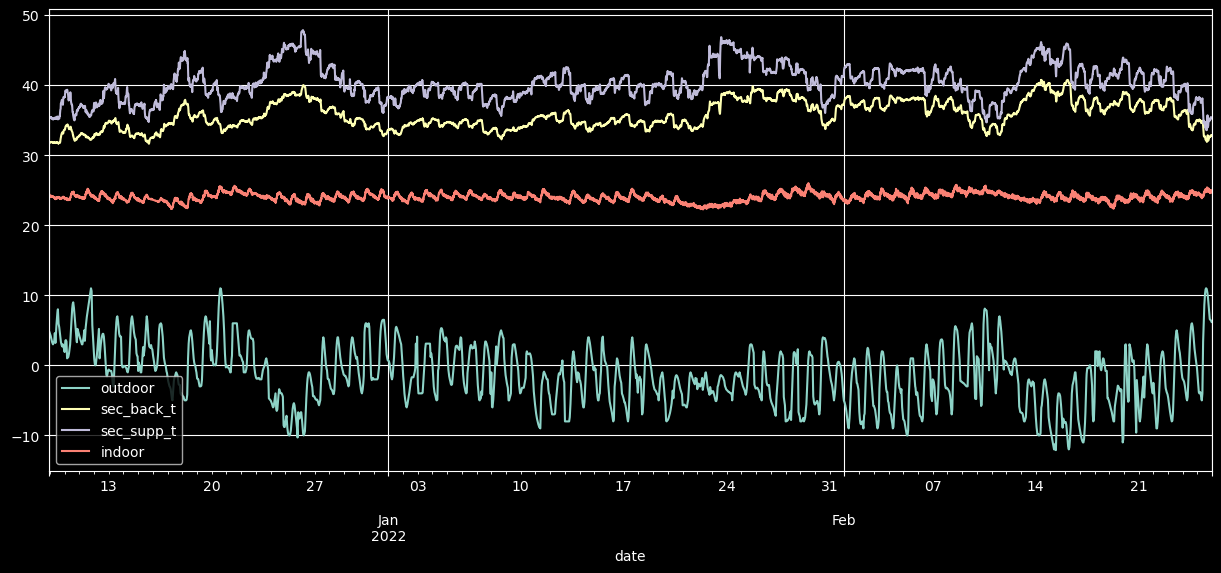

In [3]:
train_data[['outdoor', 'sec_back_t', 'sec_supp_t', 'indoor']].plot(
    figsize=(15, 6), 
    grid=True
)
train_data.head()

### Split

In [4]:
def train_val_split(X: pd.DataFrame, y: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        
    # train val split
    train_idx = (X.index <= '2021-12-20') | \
                (X.index >= '2022-1-1') & (y.index <= '2022-1-20') | \
                (X.index >= '2022-2-1') & (y.index <= '2022-2-20')
    val_idx =  ~train_idx

    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]

    return X_train, y_train, X_val, y_val

X_indoor = train_data.drop(columns=['indoor'])
y_indoor = train_data[['indoor']]

X_sec_back_t = train_data.drop(columns=['sec_back_t', 'indoor'])
y_sec_back_t = train_data[['sec_back_t']]

X_indoor, y_indoor, \
X_sec_back_t, y_sec_back_t, \
X_indoor_train, y_indoor_train, \
X_indoor_val, y_indoor_val, \
X_sec_back_t_train, y_sec_back_t_train, \
X_sec_back_t_val, y_sec_back_t_val = \
    map(lambda x: torch.tensor(x.values, dtype=torch.float32), 
        (X_indoor, y_indoor, X_sec_back_t, y_sec_back_t) + \
        train_val_split(X_indoor, y_indoor) + \
        train_val_split(X_sec_back_t, y_sec_back_t)
    )

indoor_train_dataset = TensorDataset(X_indoor_train, y_indoor_train)
indoor_val_dataset = TensorDataset(X_indoor_val, y_indoor_val)
sec_back_t_train_dataset = TensorDataset(X_sec_back_t_train, y_sec_back_t_train)    
sec_back_t_val_dataset = TensorDataset(X_sec_back_t_val, y_sec_back_t_val)

indoor_train_dataloader = DataLoader(indoor_train_dataset, batch_size=64, shuffle=True)
indoor_val_dataloader = DataLoader(indoor_val_dataset, batch_size=64, shuffle=False)
sec_back_t_train_dataloader = DataLoader(sec_back_t_train_dataset, batch_size=64, shuffle=True)
sec_back_t_val_dataloader = DataLoader(sec_back_t_val_dataset, batch_size=64, shuffle=False)

print(X_indoor_train.shape, y_indoor_train.shape, X_indoor_val.shape, y_indoor_val.shape)


torch.Size([7067, 9]) torch.Size([7067, 1]) torch.Size([4312, 9]) torch.Size([4312, 1])


### Model

In [5]:
class MLPModel(pl.LightningModule):
    def __init__(self, 
                 input_dim, 
                 output_dim=1,
                 hidden_dim=[64, 64, 64],
                 dropout=0.4,
                 gamma=0.001
                ):
        super().__init__()

        self.gamma = gamma

        layers = []
        for in_dim, out_dim in zip([input_dim] + hidden_dim[:-1], hidden_dim):
            layers.append(nn.Linear(in_dim, out_dim))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(out_dim))
            layers.append(nn.Dropout(dropout))

        layers.append(nn.Linear(hidden_dim[-1], output_dim))
        self.linear = nn.Sequential(*layers)
        self.save_hyperparameters()

    def forward(self, x):
        return self.linear(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = nn.functional.mse_loss(y_pred, y)
        
        for param in self.parameters():
            loss += self.gamma * torch.norm(param, 2)

        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = F.mse_loss(y_pred, y)
        self.log('val_loss', loss)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5, verbose=True),
                "monitor": "val_loss",
                "frequency": 100,
            },
        }


sec_back_t_model = MLPModel(input_dim=X_sec_back_t_train.shape[1])
indoor_model = MLPModel(input_dim=X_indoor_train.shape[1])

### Train

In [ ]:
trainer = pl.Trainer(max_epochs=1000)
trainer.fit(sec_back_t_model, sec_back_t_train_dataloader, sec_back_t_val_dataloader)


In [ ]:
trainer = pl.Trainer(max_epochs=1000)
trainer.fit(indoor_model, indoor_train_dataloader, indoor_val_dataloader)


### Eval

tensor(0.0673)


<Axes: xlabel='date'>

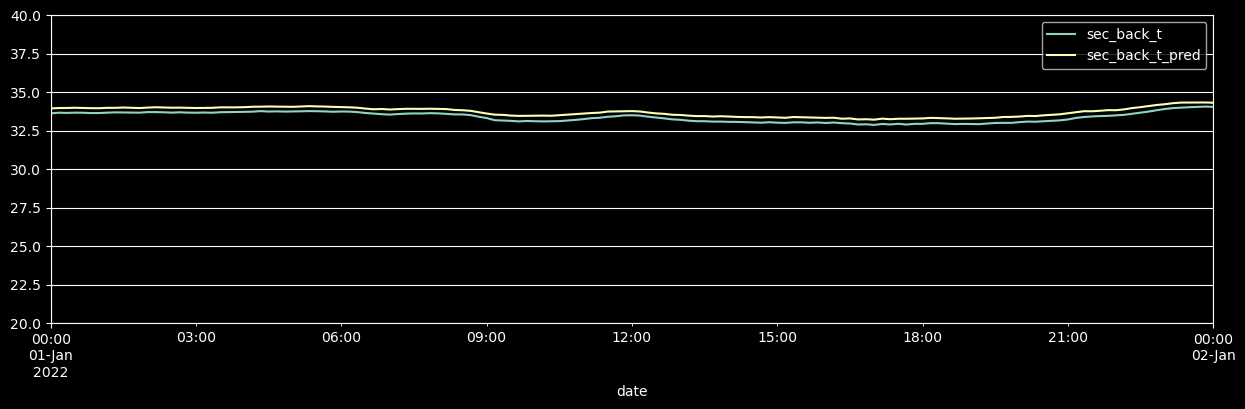

In [9]:
sec_back_t_model = MLPModel.load_from_checkpoint('lightning_logs/split-back/checkpoints/epoch=3060-step=339771.ckpt')

sec_back_t_model.eval()
with torch.no_grad():    
    sec_back_t_pred = sec_back_t_model(X_sec_back_t.to(sec_back_t_model.device)).cpu()

print(F.mse_loss(sec_back_t_pred, y_sec_back_t) / len(y_sec_back_t))

sec_back_t_pred = sec_back_t_pred.numpy()

pd.DataFrame({
    'sec_back_t': y_sec_back_t.flatten(),
    'sec_back_t_pred': sec_back_t_pred.flatten()
}, index=train_data.index).plot(
    figsize=(15, 4),
    xlim=('2022-1-1', '2022-1-2'),
    ylim=(20, 40),
    grid=True,
)


tensor(0.1833)


<Axes: xlabel='date'>

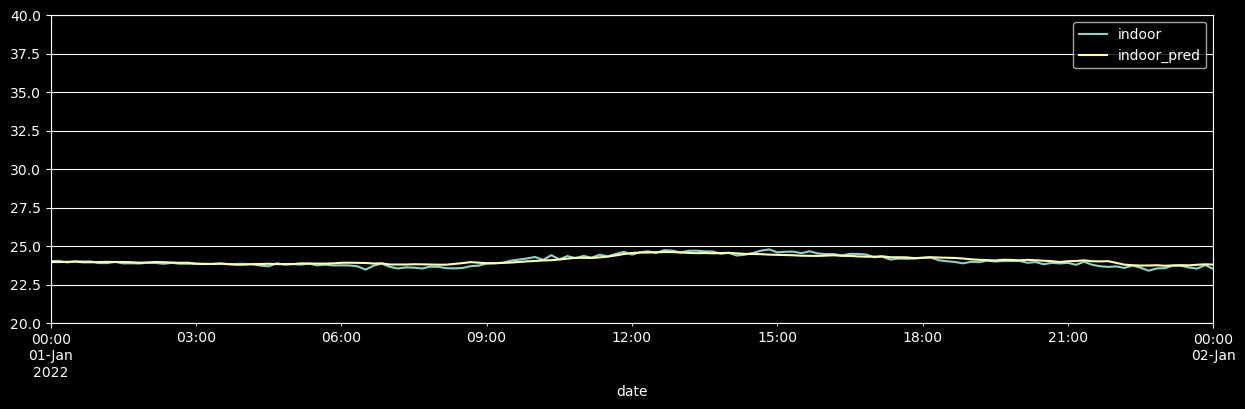

In [11]:
indoor_model = MLPModel.load_from_checkpoint('lightning_logs/split-indoor/checkpoints/epoch=1308-step=145299.ckpt')

indoor_model.eval()
with torch.no_grad():    
    indoor_pred = indoor_model(X_indoor.to(indoor_model.device)).cpu()

print(F.mse_loss(indoor_pred, y_indoor) / len(y_indoor))

indoor_pred = indoor_pred.numpy()

pd.DataFrame({
    'indoor': y_indoor.flatten(),
    'indoor_pred': indoor_pred.flatten()
}, index=train_data.index).plot(
    figsize=(15, 4),
    xlim=('2022-1-1', '2022-1-2'),
    ylim=(20, 40),
    grid=True,
)
